In [6]:
import torch
a = torch.tensor([-1,2,3])
m = torch.maximum(a,torch.tensor(0))
m

tensor([0, 2, 3])

In [ ]:
        location_channel = np.zeros((120,2), dtype=np.float32)
        for i,cen in enumerate(centers):
            location_channel[i] = cen
        head = centers[-1,:]
        gt_label = centers[gaze_idx,:]

In [ ]:
            depthk,xyzk = model(img,face,location_channel,heads,lenght)
            depth = depthk.squeeze(1)
            depth = depth.detach().cpu().data.numpy()
            xyzz = xyzk.detach().cpu().data.numpy()
            centers = location_channel[0,:,:]
            space = depth[0,:,:]
            head = np.array([heads[0,0],heads[0,1],space[heads[0,1],heads[0,0]]])
            gt_label = np.array([gt_labels[0,0],gt_labels[0,1],space[gt_labels[0,1],gt_labels[0,0]]])
            xyz = xyzz[0,:]
            distance = np.array([d([int(centers[x,0].item()),int(centers[x,1].item()),space[int(centers[x,1].item()),int(centers[x,0].item())]],head,xyz) for x in list(range(lenght[0]))])
            predict_center_index = np.argmax(distance)
            predict_center = torch.from_numpy(np.array([int(centers[predict_center_index,0].item()),int(centers[predict_center_index,1].item()),space[int(centers[predict_center_index,1].item()),int(centers[predict_center_index,0].item())]]))
            real_center = torch.from_numpy(gt_label)
            predict_center.requires_grad_(True)
            real_center.requires_grad_(True)
            loss = criterion(predict_center,real_center)
            for i in range(1,depthk.shape[0]):
                centers = location_channel[i,:,:]
                space = depth[i,:,:]
                head = np.array([heads[i,0],heads[i,1],space[heads[i,1],heads[i,0]]])
                gt_label = np.array([gt_labels[i,0],gt_labels[i,1],space[gt_labels[i,1],gt_labels[i,0]]])
                xyz = xyzz[i,:]
                distance = np.array([d([int(centers[x,0].item()),int(centers[x,1].item()),space[int(centers[x,1].item()),int(centers[x,0].item())]],head,xyz) for x in list(range(lenght[i]))])
                predict_center_index = np.argmax(distance)
                predict_center = torch.from_numpy(np.array([int(centers[predict_center_index,0].item()),int(centers[predict_center_index,1].item()),space[int(centers[predict_center_index,1].item()),int(centers[predict_center_index,0].item())]]))
                real_center = torch.from_numpy(gt_label)
                predict_center.requires_grad_(True)
                real_center.requires_grad_(True)
                loss += criterion(predict_center,real_center)

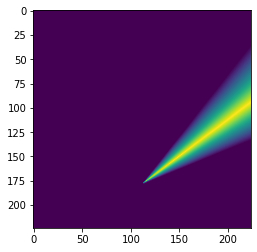

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
mask = torch.zeros(4,224,224)
xy = torch.tensor([[0.6317, 0.4746],[0.6317, 0.4746],[0.6317, 0.4746],[0.6317, 0.4746]],dtype=torch.float32).cuda()
head = torch.tensor([[112, 23],[56, 112],[112, 45],[112, 45]],dtype=torch.float32).cuda()
for batch in range(mask.shape[0]):
    for i in range(224):
        for k in range(224):
            arr = torch.tensor([k,i],dtype=torch.float32).cuda() - head[batch,:]
            mask[batch,223-i,k] = torch.dot(arr,xy[batch,:])/(torch.norm(arr,p=2)*torch.norm(xy[batch,:],p=2))
mask = torch.arccos(mask)
mask = torch.maximum(1-(12*mask/np.pi),torch.tensor(0))
mask = torch.nan_to_num(mask)
plt.imshow(mask[2])

/tmp/ipykernel_53778/2371250875.py:13: RuntimeWarning: invalid value encountered in double_scalars
  mask[i][k] = np.dot(arr,g)/(np.linalg.norm(arr,2)*np.linalg.norm(g,2))


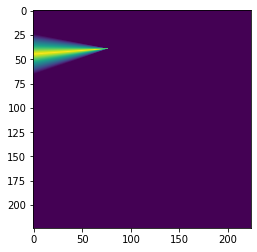

In [22]:
import numpy as np
import matplotlib.pyplot as plt
mask = np.zeros((224,224))
h = np.array([77, 39])
yp = np.array([-0.8877,  0.0559])
g = np.around(np.array([np.cos(yp[1])*np.sin(yp[0]),np.sin(yp[1]),np.cos(yp[0])*np.cos(yp[1])]),5)
g = g[:2]
# g = np.array([-0.1270,  0.1844])
# print(g)
for i in range(224):
  for k in range(224):
    arr = np.array([k,i]) - h
    mask[i][k] = np.dot(arr,g)/(np.linalg.norm(arr,2)*np.linalg.norm(g,2))
mask = np.arccos(mask)
mask = np.maximum(1-(12*mask/np.pi),0)
mask[np.isnan(mask)] = 0
plt.imshow(mask)

In [4]:
import torch
import cv2
midas = torch.hub.load("intel-isl/MiDaS", "DPT_Hybrid")
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
model_type = "DPT_Hybrid"
if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform
img = cv2.imread("/home/shashimal/Desktop/gooreal/finalrealdatasetImgsV2/0/cam0/cam00000_img00123.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

input_batch = transform(img).to(device)    
with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(

        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

output = prediction.cpu().numpy()    

RuntimeError: KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


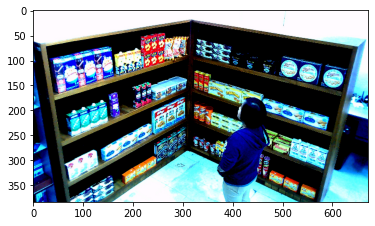

In [29]:
input_batch = input_batch.cpu().data.numpy()
plt.imshow(np.transpose(input_batch[0],(1,2,0)))
plt.savefig("j.png")

In [5]:
output = output/255.0

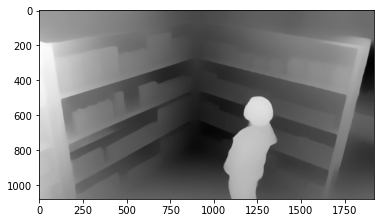

In [8]:
plt.imshow(output,cmap="gray")

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import DataParallel


import time
import os
import numpy as np
import json
import cv2
from PIL import Image, ImageOps
import random
from tqdm import tqdm
import operator
import itertools
from scipy.io import  loadmat
import logging

from scipy import signal
import matplotlib.pyplot as plt


import pickle
from skimage import io
from dataloader import chong_imutils

import pandas as pd
np.random.seed(1)
images_dir = '/media/primesh/F4D0EA80D0EA4906/PROJECTS/FYP/Gaze detection/Datasets/gooreal/finalrealdatasetImgsV2'
pickle_path = '/media/primesh/F4D0EA80D0EA4906/PROJECTS/FYP/Gaze detection/Datasets/gooreal/oneshotrealhumansNew.pickle'
test_images_dir = '/media/primesh/F4D0EA80D0EA4906/PROJECTS/FYP/Gaze detection/Datasets/gooreal/finalrealdatasetImgsV2'
test_pickle_path = '/media/primesh/F4D0EA80D0EA4906/PROJECTS/FYP/Gaze detection/Datasets/gooreal/testrealhumansNew.pickle'
val_images_dir = '/media/primesh/F4D0EA80D0EA4906/PROJECTS/FYP/Gaze detection/Datasets/gooreal/finalrealdatasetImgsV2'
val_pickle_path = '/media/primesh/F4D0EA80D0EA4906/PROJECTS/FYP/Gaze detection/Datasets/gooreal/valrealhumansNew.pickle'
with open(pickle_path, 'rb') as f:
    datas = pickle.load(f) 
with open(test_pickle_path, 'rb') as f:
    test_datas = pickle.load(f) 
with open(val_pickle_path, 'rb') as f:
    val_datas = pickle.load(f)  
data = None
for d in test_datas:
    if d['filename'] == "0\cam0\cam00000_img00123.jpg":
        data = d    

In [10]:
data

{'filename': '0\\cam0\\cam00000_img00123.jpg',
 'width': 1920,
 'height': 1080,
 'ann': {'bboxes': array([[ 30., 109.,  88., 208.],
         [ 72.,  98., 121., 192.],
         [110.,  89., 154., 176.],
         [155., 104., 178., 163.],
         [174., 101., 194., 157.],
         [189.,  95., 208., 151.],
         [205.,  62., 224., 106.],
         [219.,  59., 237., 101.],
         [233.,  56., 252.,  97.],
         [206., 103., 224., 145.],
         [224.,  99., 238., 139.],
         [238.,  96., 251., 134.],
         [251.,  72., 273., 126.],
         [253.,  68., 286., 118.],
         [266.,  65., 297., 112.],
         [258., 165., 294., 202.],
         [237., 174., 274., 213.],
         [226., 184., 254., 225.],
         [210., 179., 226., 235.],
         [200., 184., 216., 240.],
         [189., 189., 206., 246.],
         [143., 205., 166., 268.],
         [120., 224., 143., 285.],
         [101., 232., 127., 294.],
         [ 83., 242., 109., 304.],
         [ 63., 250.,  91., 

In [76]:
from dataloader.shashimal6 import GooDataset

# Dataloaders for GOO-Real
batch_size=4
workers=12
images_dir = '/media/primesh/F4D0EA80D0EA4906/PROJECTS/FYP/Gaze detection/Datasets/gooreal/finalrealdatasetImgsV2'
pickle_path = '/media/primesh/F4D0EA80D0EA4906/PROJECTS/FYP/Gaze detection/Datasets/gooreal/oneshotrealhumansNew.pickle'
test_images_dir = '/media/primesh/F4D0EA80D0EA4906/PROJECTS/FYP/Gaze detection/Datasets/gooreal/finalrealdatasetImgsV2'
test_pickle_path = '/media/primesh/F4D0EA80D0EA4906/PROJECTS/FYP/Gaze detection/Datasets/gooreal/testrealhumansNew.pickle'
val_images_dir = '/media/primesh/F4D0EA80D0EA4906/PROJECTS/FYP/Gaze detection/Datasets/gooreal/finalrealdatasetImgsV2'
val_pickle_path = '/media/primesh/F4D0EA80D0EA4906/PROJECTS/FYP/Gaze detection/Datasets/gooreal/valrealhumansNew.pickle'


def pad_x_collate_function(batch):
    # batch looks like [(x0,y0), (x4,y4), (x2,y2)... ]
    img, face, head_channel, object_channel,gaze_final,eye,gaze_idx,gt_bboxes,gt_labels = zip(*batch)

    # If you want to be a little fancy, you can do the above in one line
    # xs, ys = zip(*samples)
    img = pad_sequence(img, batch_first=True, padding_value=0)
    face = pad_sequence(face, batch_first=True, padding_value=0)
    head_channel = pad_sequence(head_channel, batch_first=True, padding_value=0)
    object_channel = pad_sequence(object_channel, batch_first=True, padding_value=0)
    #eye = pad_sequence(eye, batch_first=True, padding_value=0)
    #gaze = pad_sequence(gaze, batch_first=True, padding_value=0)
    #gtbox = pad_sequence(gtbox, batch_first=True, padding_value=0)
    #gt_bboxes = pad_sequence(gt_bboxes, batch_first=True, padding_value=0)
    return img, face, head_channel, object_channel,gaze_final,eye,gaze_idx,zip(*gt_bboxes),zip(*gt_labels)


print ('Train')
train_set = GooDataset(images_dir, pickle_path, 'train')
train_data_loader = DataLoader(dataset=train_set,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=16)
print ('Val')
val_set = GooDataset(val_images_dir, val_pickle_path, 'train')
val_data_loader = DataLoader(dataset=val_set,
                                           batch_size=4,
                                           shuffle=True,
                                           num_workers=16)
print ('Test')
test_set = GooDataset(test_images_dir, test_pickle_path, 'test')
test_data_loader = DataLoader(test_set, batch_size=batch_size//2,
                            shuffle=False, num_workers=8)


Train
Number of Images: 2450
Val
Number of Images: 1633
Test
Number of Images: 2146


In [21]:
def boxes2centers(normalized_boxes):
    center_x = (normalized_boxes[:,0] + normalized_boxes[:,2]) / 2
    center_y = (normalized_boxes[:,1] + normalized_boxes[:,3]) / 2
    center_x = np.expand_dims(center_x, axis=1)
    center_y = np.expand_dims(center_y, axis=1)
    normalized_centers = np.hstack((center_x, center_y))
    return normalized_centers   
boxes = np.array(data['ann']['bboxes'])
centers = (boxes2centers(boxes)).astype(int)   
points = []
location_channel = np.zeros((480,640), dtype=np.float32)
count = 0
for cen in centers:
    count+=1
    location_channel[cen[1],cen[0]] =1
print (count)

95


In [27]:
plt.imshow(location_channel)

In [28]:
plt.savefig('location_channel.png')

In [45]:
depth = cv2.imread('cam00000_img00123_depth.png', 0)

In [46]:
depth.shape

(1080, 1920)

In [69]:
np.min(depth)

2

In [61]:
# make normalized 3d points 
points = []
for cen in centers:
    point = [cen[0]/640, cen[1]/480, depth[cen[1], cen[0]]/np.max(depth)]
    points.append(point)
points = np.array(points)    

In [62]:
points.shape

(95, 3)

In [63]:
location_channel = np.zeros((1080,1920), dtype=np.float32)
for cen in centers:
    location_channel[cen[1],cen[0]] =1

In [77]:
data

{'filename': '0\\cam0\\cam00000_img00123.jpg',
 'width': 1920,
 'height': 1080,
 'ann': {'bboxes': array([[ 30., 109.,  88., 208.],
         [ 72.,  98., 121., 192.],
         [110.,  89., 154., 176.],
         [155., 104., 178., 163.],
         [174., 101., 194., 157.],
         [189.,  95., 208., 151.],
         [205.,  62., 224., 106.],
         [219.,  59., 237., 101.],
         [233.,  56., 252.,  97.],
         [206., 103., 224., 145.],
         [224.,  99., 238., 139.],
         [238.,  96., 251., 134.],
         [251.,  72., 273., 126.],
         [253.,  68., 286., 118.],
         [266.,  65., 297., 112.],
         [258., 165., 294., 202.],
         [237., 174., 274., 213.],
         [226., 184., 254., 225.],
         [210., 179., 226., 235.],
         [200., 184., 216., 240.],
         [189., 189., 206., 246.],
         [143., 205., 166., 268.],
         [120., 224., 143., 285.],
         [101., 232., 127., 294.],
         [ 83., 242., 109., 304.],
         [ 63., 250.,  91., 

In [2]:
from PIL import Image
root_dir = "/media/primesh/F4D0EA80D0EA4906/PROJECTS/FYP/Gaze detection/Datasets/gooreal/finalrealdatasetImgsV2"
image_path = data['filename']
image_path = os.path.join(root_dir, image_path)
image_path = image_path.replace('\\', '/')
img = Image.open(image_path)
img = img.convert('RGB')
width, height = img.size
gt_bboxes = np.array(data['ann']['bboxes']) / [640, 480, 640, 480]
x_min, y_min, x_max, y_max = gt_bboxes[-1] * [width,height,width,height]
face = img.crop((int(x_min), int(y_min), int(x_max), int(y_max)))

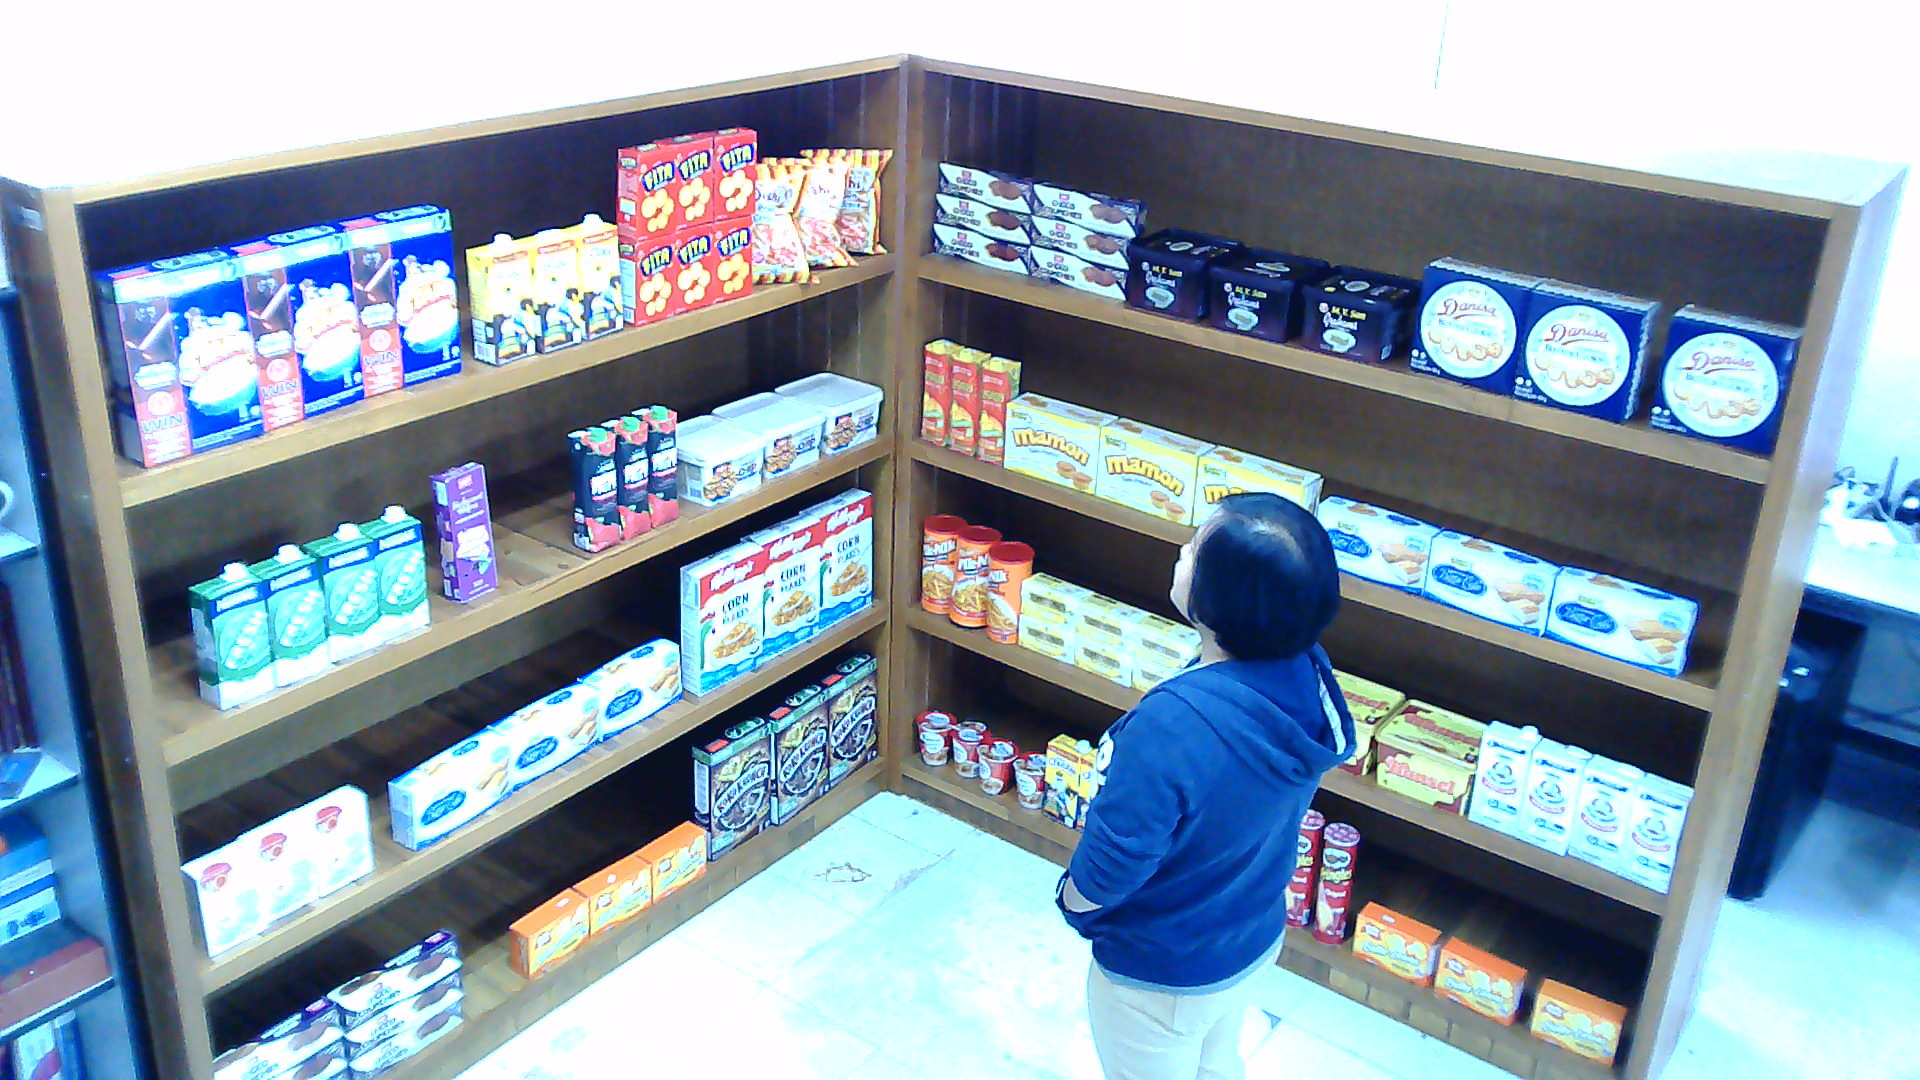

In [3]:
img

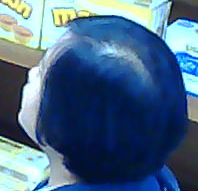

In [4]:
face

In [5]:
def _get_transform(input_resolution):
    transform_list = []
    transform_list.append(transforms.Resize((input_resolution, input_resolution)))
    transform_list.append(transforms.ToTensor())
    transform_list.append(transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))
    return transforms.Compose(transform_list)

def _get_transform2():
    transform_list = []
    transform_list.append(transforms.Resize((448, 448)))
    transform_list.append(transforms.ToTensor())
    transform_list.append(transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))
    return transforms.Compose(transform_list)

transform = _get_transform(224)
img = transform(img)
image = img.cuda()
transform2 = _get_transform2()
face= transform2(face)
face= face.cuda()

In [6]:
image = image.unsqueeze(0)
face = face.unsqueeze(0)
image.shape, face.shape

(torch.Size([1, 3, 224, 224]), torch.Size([1, 3, 448, 448]))

In [7]:
torch.cuda.empty_cache()

In [8]:
# Load model
from models.primesh3 import Shashimal6_Face3D
model = Shashimal6_Face3D().cuda()
checkpoint_fpath = '/media/primesh/F4D0EA80D0EA4906/PROJECTS/FYP/Gaze detection/saved_weights/shashimal6_face_43.pt'
checkpoint = torch.load(checkpoint_fpath)
model.load_state_dict(checkpoint['state_dict'])
gaze, depth = model(image,face)

Using cache found in /home/primesh/.cache/torch/hub/intel-isl_MiDaS_master


RuntimeError: Error(s) in loading state_dict for Shashimal6_Face3D:
	Missing key(s) in state_dict: "backbone.conv1.0.weight", "backbone.conv1.1.weight", "backbone.conv1.1.bias", "backbone.conv1.1.running_mean", "backbone.conv1.1.running_var", "backbone.conv1.3.weight", "backbone.conv1.4.weight", "backbone.conv1.4.bias", "backbone.conv1.4.running_mean", "backbone.conv1.4.running_var", "backbone.conv1.6.weight", "backbone.bn1.weight", "backbone.bn1.bias", "backbone.bn1.running_mean", "backbone.bn1.running_var", "backbone.layer1.0.conv1.weight", "backbone.layer1.0.bn1.weight", "backbone.layer1.0.bn1.bias", "backbone.layer1.0.bn1.running_mean", "backbone.layer1.0.bn1.running_var", "backbone.layer1.0.conv2.conv.weight", "backbone.layer1.0.conv2.bn0.weight", "backbone.layer1.0.conv2.bn0.bias", "backbone.layer1.0.conv2.bn0.running_mean", "backbone.layer1.0.conv2.bn0.running_var", "backbone.layer1.0.conv2.fc1.weight", "backbone.layer1.0.conv2.fc1.bias", "backbone.layer1.0.conv2.bn1.weight", "backbone.layer1.0.conv2.bn1.bias", "backbone.layer1.0.conv2.bn1.running_mean", "backbone.layer1.0.conv2.bn1.running_var", "backbone.layer1.0.conv2.fc2.weight", "backbone.layer1.0.conv2.fc2.bias", "backbone.layer1.0.conv3.weight", "backbone.layer1.0.bn3.weight", "backbone.layer1.0.bn3.bias", "backbone.layer1.0.bn3.running_mean", "backbone.layer1.0.bn3.running_var", "backbone.layer1.0.downsample.1.weight", "backbone.layer1.0.downsample.2.weight", "backbone.layer1.0.downsample.2.bias", "backbone.layer1.0.downsample.2.running_mean", "backbone.layer1.0.downsample.2.running_var", "backbone.layer1.1.conv1.weight", "backbone.layer1.1.bn1.weight", "backbone.layer1.1.bn1.bias", "backbone.layer1.1.bn1.running_mean", "backbone.layer1.1.bn1.running_var", "backbone.layer1.1.conv2.conv.weight", "backbone.layer1.1.conv2.bn0.weight", "backbone.layer1.1.conv2.bn0.bias", "backbone.layer1.1.conv2.bn0.running_mean", "backbone.layer1.1.conv2.bn0.running_var", "backbone.layer1.1.conv2.fc1.weight", "backbone.layer1.1.conv2.fc1.bias", "backbone.layer1.1.conv2.bn1.weight", "backbone.layer1.1.conv2.bn1.bias", "backbone.layer1.1.conv2.bn1.running_mean", "backbone.layer1.1.conv2.bn1.running_var", "backbone.layer1.1.conv2.fc2.weight", "backbone.layer1.1.conv2.fc2.bias", "backbone.layer1.1.conv3.weight", "backbone.layer1.1.bn3.weight", "backbone.layer1.1.bn3.bias", "backbone.layer1.1.bn3.running_mean", "backbone.layer1.1.bn3.running_var", "backbone.layer1.2.conv1.weight", "backbone.layer1.2.bn1.weight", "backbone.layer1.2.bn1.bias", "backbone.layer1.2.bn1.running_mean", "backbone.layer1.2.bn1.running_var", "backbone.layer1.2.conv2.conv.weight", "backbone.layer1.2.conv2.bn0.weight", "backbone.layer1.2.conv2.bn0.bias", "backbone.layer1.2.conv2.bn0.running_mean", "backbone.layer1.2.conv2.bn0.running_var", "backbone.layer1.2.conv2.fc1.weight", "backbone.layer1.2.conv2.fc1.bias", "backbone.layer1.2.conv2.bn1.weight", "backbone.layer1.2.conv2.bn1.bias", "backbone.layer1.2.conv2.bn1.running_mean", "backbone.layer1.2.conv2.bn1.running_var", "backbone.layer1.2.conv2.fc2.weight", "backbone.layer1.2.conv2.fc2.bias", "backbone.layer1.2.conv3.weight", "backbone.layer1.2.bn3.weight", "backbone.layer1.2.bn3.bias", "backbone.layer1.2.bn3.running_mean", "backbone.layer1.2.bn3.running_var", "backbone.layer2.0.conv1.weight", "backbone.layer2.0.bn1.weight", "backbone.layer2.0.bn1.bias", "backbone.layer2.0.bn1.running_mean", "backbone.layer2.0.bn1.running_var", "backbone.layer2.0.conv2.conv.weight", "backbone.layer2.0.conv2.bn0.weight", "backbone.layer2.0.conv2.bn0.bias", "backbone.layer2.0.conv2.bn0.running_mean", "backbone.layer2.0.conv2.bn0.running_var", "backbone.layer2.0.conv2.fc1.weight", "backbone.layer2.0.conv2.fc1.bias", "backbone.layer2.0.conv2.bn1.weight", "backbone.layer2.0.conv2.bn1.bias", "backbone.layer2.0.conv2.bn1.running_mean", "backbone.layer2.0.conv2.bn1.running_var", "backbone.layer2.0.conv2.fc2.weight", "backbone.layer2.0.conv2.fc2.bias", "backbone.layer2.0.conv3.weight", "backbone.layer2.0.bn3.weight", "backbone.layer2.0.bn3.bias", "backbone.layer2.0.bn3.running_mean", "backbone.layer2.0.bn3.running_var", "backbone.layer2.0.downsample.1.weight", "backbone.layer2.0.downsample.2.weight", "backbone.layer2.0.downsample.2.bias", "backbone.layer2.0.downsample.2.running_mean", "backbone.layer2.0.downsample.2.running_var", "backbone.layer2.1.conv1.weight", "backbone.layer2.1.bn1.weight", "backbone.layer2.1.bn1.bias", "backbone.layer2.1.bn1.running_mean", "backbone.layer2.1.bn1.running_var", "backbone.layer2.1.conv2.conv.weight", "backbone.layer2.1.conv2.bn0.weight", "backbone.layer2.1.conv2.bn0.bias", "backbone.layer2.1.conv2.bn0.running_mean", "backbone.layer2.1.conv2.bn0.running_var", "backbone.layer2.1.conv2.fc1.weight", "backbone.layer2.1.conv2.fc1.bias", "backbone.layer2.1.conv2.bn1.weight", "backbone.layer2.1.conv2.bn1.bias", "backbone.layer2.1.conv2.bn1.running_mean", "backbone.layer2.1.conv2.bn1.running_var", "backbone.layer2.1.conv2.fc2.weight", "backbone.layer2.1.conv2.fc2.bias", "backbone.layer2.1.conv3.weight", "backbone.layer2.1.bn3.weight", "backbone.layer2.1.bn3.bias", "backbone.layer2.1.bn3.running_mean", "backbone.layer2.1.bn3.running_var", "backbone.layer2.2.conv1.weight", "backbone.layer2.2.bn1.weight", "backbone.layer2.2.bn1.bias", "backbone.layer2.2.bn1.running_mean", "backbone.layer2.2.bn1.running_var", "backbone.layer2.2.conv2.conv.weight", "backbone.layer2.2.conv2.bn0.weight", "backbone.layer2.2.conv2.bn0.bias", "backbone.layer2.2.conv2.bn0.running_mean", "backbone.layer2.2.conv2.bn0.running_var", "backbone.layer2.2.conv2.fc1.weight", "backbone.layer2.2.conv2.fc1.bias", "backbone.layer2.2.conv2.bn1.weight", "backbone.layer2.2.conv2.bn1.bias", "backbone.layer2.2.conv2.bn1.running_mean", "backbone.layer2.2.conv2.bn1.running_var", "backbone.layer2.2.conv2.fc2.weight", "backbone.layer2.2.conv2.fc2.bias", "backbone.layer2.2.conv3.weight", "backbone.layer2.2.bn3.weight", "backbone.layer2.2.bn3.bias", "backbone.layer2.2.bn3.running_mean", "backbone.layer2.2.bn3.running_var", "backbone.layer2.3.conv1.weight", "backbone.layer2.3.bn1.weight", "backbone.layer2.3.bn1.bias", "backbone.layer2.3.bn1.running_mean", "backbone.layer2.3.bn1.running_var", "backbone.layer2.3.conv2.conv.weight", "backbone.layer2.3.conv2.bn0.weight", "backbone.layer2.3.conv2.bn0.bias", "backbone.layer2.3.conv2.bn0.running_mean", "backbone.layer2.3.conv2.bn0.running_var", "backbone.layer2.3.conv2.fc1.weight", "backbone.layer2.3.conv2.fc1.bias", "backbone.layer2.3.conv2.bn1.weight", "backbone.layer2.3.conv2.bn1.bias", "backbone.layer2.3.conv2.bn1.running_mean", "backbone.layer2.3.conv2.bn1.running_var", "backbone.layer2.3.conv2.fc2.weight", "backbone.layer2.3.conv2.fc2.bias", "backbone.layer2.3.conv3.weight", "backbone.layer2.3.bn3.weight", "backbone.layer2.3.bn3.bias", "backbone.layer2.3.bn3.running_mean", "backbone.layer2.3.bn3.running_var", "backbone.layer3.0.conv1.weight", "backbone.layer3.0.bn1.weight", "backbone.layer3.0.bn1.bias", "backbone.layer3.0.bn1.running_mean", "backbone.layer3.0.bn1.running_var", "backbone.layer3.0.conv2.conv.weight", "backbone.layer3.0.conv2.bn0.weight", "backbone.layer3.0.conv2.bn0.bias", "backbone.layer3.0.conv2.bn0.running_mean", "backbone.layer3.0.conv2.bn0.running_var", "backbone.layer3.0.conv2.fc1.weight", "backbone.layer3.0.conv2.fc1.bias", "backbone.layer3.0.conv2.bn1.weight", "backbone.layer3.0.conv2.bn1.bias", "backbone.layer3.0.conv2.bn1.running_mean", "backbone.layer3.0.conv2.bn1.running_var", "backbone.layer3.0.conv2.fc2.weight", "backbone.layer3.0.conv2.fc2.bias", "backbone.layer3.0.conv3.weight", "backbone.layer3.0.bn3.weight", "backbone.layer3.0.bn3.bias", "backbone.layer3.0.bn3.running_mean", "backbone.layer3.0.bn3.running_var", "backbone.layer3.0.downsample.1.weight", "backbone.layer3.0.downsample.2.weight", "backbone.layer3.0.downsample.2.bias", "backbone.layer3.0.downsample.2.running_mean", "backbone.layer3.0.downsample.2.running_var", "backbone.layer3.1.conv1.weight", "backbone.layer3.1.bn1.weight", "backbone.layer3.1.bn1.bias", "backbone.layer3.1.bn1.running_mean", "backbone.layer3.1.bn1.running_var", "backbone.layer3.1.conv2.conv.weight", "backbone.layer3.1.conv2.bn0.weight", "backbone.layer3.1.conv2.bn0.bias", "backbone.layer3.1.conv2.bn0.running_mean", "backbone.layer3.1.conv2.bn0.running_var", "backbone.layer3.1.conv2.fc1.weight", "backbone.layer3.1.conv2.fc1.bias", "backbone.layer3.1.conv2.bn1.weight", "backbone.layer3.1.conv2.bn1.bias", "backbone.layer3.1.conv2.bn1.running_mean", "backbone.layer3.1.conv2.bn1.running_var", "backbone.layer3.1.conv2.fc2.weight", "backbone.layer3.1.conv2.fc2.bias", "backbone.layer3.1.conv3.weight", "backbone.layer3.1.bn3.weight", "backbone.layer3.1.bn3.bias", "backbone.layer3.1.bn3.running_mean", "backbone.layer3.1.bn3.running_var", "backbone.layer3.2.conv1.weight", "backbone.layer3.2.bn1.weight", "backbone.layer3.2.bn1.bias", "backbone.layer3.2.bn1.running_mean", "backbone.layer3.2.bn1.running_var", "backbone.layer3.2.conv2.conv.weight", "backbone.layer3.2.conv2.bn0.weight", "backbone.layer3.2.conv2.bn0.bias", "backbone.layer3.2.conv2.bn0.running_mean", "backbone.layer3.2.conv2.bn0.running_var", "backbone.layer3.2.conv2.fc1.weight", "backbone.layer3.2.conv2.fc1.bias", "backbone.layer3.2.conv2.bn1.weight", "backbone.layer3.2.conv2.bn1.bias", "backbone.layer3.2.conv2.bn1.running_mean", "backbone.layer3.2.conv2.bn1.running_var", "backbone.layer3.2.conv2.fc2.weight", "backbone.layer3.2.conv2.fc2.bias", "backbone.layer3.2.conv3.weight", "backbone.layer3.2.bn3.weight", "backbone.layer3.2.bn3.bias", "backbone.layer3.2.bn3.running_mean", "backbone.layer3.2.bn3.running_var", "backbone.layer3.3.conv1.weight", "backbone.layer3.3.bn1.weight", "backbone.layer3.3.bn1.bias", "backbone.layer3.3.bn1.running_mean", "backbone.layer3.3.bn1.running_var", "backbone.layer3.3.conv2.conv.weight", "backbone.layer3.3.conv2.bn0.weight", "backbone.layer3.3.conv2.bn0.bias", "backbone.layer3.3.conv2.bn0.running_mean", "backbone.layer3.3.conv2.bn0.running_var", "backbone.layer3.3.conv2.fc1.weight", "backbone.layer3.3.conv2.fc1.bias", "backbone.layer3.3.conv2.bn1.weight", "backbone.layer3.3.conv2.bn1.bias", "backbone.layer3.3.conv2.bn1.running_mean", "backbone.layer3.3.conv2.bn1.running_var", "backbone.layer3.3.conv2.fc2.weight", "backbone.layer3.3.conv2.fc2.bias", "backbone.layer3.3.conv3.weight", "backbone.layer3.3.bn3.weight", "backbone.layer3.3.bn3.bias", "backbone.layer3.3.bn3.running_mean", "backbone.layer3.3.bn3.running_var", "backbone.layer3.4.conv1.weight", "backbone.layer3.4.bn1.weight", "backbone.layer3.4.bn1.bias", "backbone.layer3.4.bn1.running_mean", "backbone.layer3.4.bn1.running_var", "backbone.layer3.4.conv2.conv.weight", "backbone.layer3.4.conv2.bn0.weight", "backbone.layer3.4.conv2.bn0.bias", "backbone.layer3.4.conv2.bn0.running_mean", "backbone.layer3.4.conv2.bn0.running_var", "backbone.layer3.4.conv2.fc1.weight", "backbone.layer3.4.conv2.fc1.bias", "backbone.layer3.4.conv2.bn1.weight", "backbone.layer3.4.conv2.bn1.bias", "backbone.layer3.4.conv2.bn1.running_mean", "backbone.layer3.4.conv2.bn1.running_var", "backbone.layer3.4.conv2.fc2.weight", "backbone.layer3.4.conv2.fc2.bias", "backbone.layer3.4.conv3.weight", "backbone.layer3.4.bn3.weight", "backbone.layer3.4.bn3.bias", "backbone.layer3.4.bn3.running_mean", "backbone.layer3.4.bn3.running_var", "backbone.layer3.5.conv1.weight", "backbone.layer3.5.bn1.weight", "backbone.layer3.5.bn1.bias", "backbone.layer3.5.bn1.running_mean", "backbone.layer3.5.bn1.running_var", "backbone.layer3.5.conv2.conv.weight", "backbone.layer3.5.conv2.bn0.weight", "backbone.layer3.5.conv2.bn0.bias", "backbone.layer3.5.conv2.bn0.running_mean", "backbone.layer3.5.conv2.bn0.running_var", "backbone.layer3.5.conv2.fc1.weight", "backbone.layer3.5.conv2.fc1.bias", "backbone.layer3.5.conv2.bn1.weight", "backbone.layer3.5.conv2.bn1.bias", "backbone.layer3.5.conv2.bn1.running_mean", "backbone.layer3.5.conv2.bn1.running_var", "backbone.layer3.5.conv2.fc2.weight", "backbone.layer3.5.conv2.fc2.bias", "backbone.layer3.5.conv3.weight", "backbone.layer3.5.bn3.weight", "backbone.layer3.5.bn3.bias", "backbone.layer3.5.bn3.running_mean", "backbone.layer3.5.bn3.running_var", "backbone.layer4.0.conv1.weight", "backbone.layer4.0.bn1.weight", "backbone.layer4.0.bn1.bias", "backbone.layer4.0.bn1.running_mean", "backbone.layer4.0.bn1.running_var", "backbone.layer4.0.conv2.conv.weight", "backbone.layer4.0.conv2.bn0.weight", "backbone.layer4.0.conv2.bn0.bias", "backbone.layer4.0.conv2.bn0.running_mean", "backbone.layer4.0.conv2.bn0.running_var", "backbone.layer4.0.conv2.fc1.weight", "backbone.layer4.0.conv2.fc1.bias", "backbone.layer4.0.conv2.bn1.weight", "backbone.layer4.0.conv2.bn1.bias", "backbone.layer4.0.conv2.bn1.running_mean", "backbone.layer4.0.conv2.bn1.running_var", "backbone.layer4.0.conv2.fc2.weight", "backbone.layer4.0.conv2.fc2.bias", "backbone.layer4.0.conv3.weight", "backbone.layer4.0.bn3.weight", "backbone.layer4.0.bn3.bias", "backbone.layer4.0.bn3.running_mean", "backbone.layer4.0.bn3.running_var", "backbone.layer4.0.downsample.1.weight", "backbone.layer4.0.downsample.2.weight", "backbone.layer4.0.downsample.2.bias", "backbone.layer4.0.downsample.2.running_mean", "backbone.layer4.0.downsample.2.running_var", "backbone.layer4.1.conv1.weight", "backbone.layer4.1.bn1.weight", "backbone.layer4.1.bn1.bias", "backbone.layer4.1.bn1.running_mean", "backbone.layer4.1.bn1.running_var", "backbone.layer4.1.conv2.conv.weight", "backbone.layer4.1.conv2.bn0.weight", "backbone.layer4.1.conv2.bn0.bias", "backbone.layer4.1.conv2.bn0.running_mean", "backbone.layer4.1.conv2.bn0.running_var", "backbone.layer4.1.conv2.fc1.weight", "backbone.layer4.1.conv2.fc1.bias", "backbone.layer4.1.conv2.bn1.weight", "backbone.layer4.1.conv2.bn1.bias", "backbone.layer4.1.conv2.bn1.running_mean", "backbone.layer4.1.conv2.bn1.running_var", "backbone.layer4.1.conv2.fc2.weight", "backbone.layer4.1.conv2.fc2.bias", "backbone.layer4.1.conv3.weight", "backbone.layer4.1.bn3.weight", "backbone.layer4.1.bn3.bias", "backbone.layer4.1.bn3.running_mean", "backbone.layer4.1.bn3.running_var", "backbone.layer4.2.conv1.weight", "backbone.layer4.2.bn1.weight", "backbone.layer4.2.bn1.bias", "backbone.layer4.2.bn1.running_mean", "backbone.layer4.2.bn1.running_var", "backbone.layer4.2.conv2.conv.weight", "backbone.layer4.2.conv2.bn0.weight", "backbone.layer4.2.conv2.bn0.bias", "backbone.layer4.2.conv2.bn0.running_mean", "backbone.layer4.2.conv2.bn0.running_var", "backbone.layer4.2.conv2.fc1.weight", "backbone.layer4.2.conv2.fc1.bias", "backbone.layer4.2.conv2.bn1.weight", "backbone.layer4.2.conv2.bn1.bias", "backbone.layer4.2.conv2.bn1.running_mean", "backbone.layer4.2.conv2.bn1.running_var", "backbone.layer4.2.conv2.fc2.weight", "backbone.layer4.2.conv2.fc2.bias", "backbone.layer4.2.conv3.weight", "backbone.layer4.2.bn3.weight", "backbone.layer4.2.bn3.bias", "backbone.layer4.2.bn3.running_mean", "backbone.layer4.2.bn3.running_var", "backbone.fc.weight", "backbone.fc.bias", "fc2.weight", "fc2.bias". 

In [9]:
gaze

NameError: name 'gaze' is not defined

In [139]:
head  = points[-1,:]
x=data["gaze_cx"]/640
y=data["gaze_cy"]/480
g=(x, y)
# xyz  = (np.array([-1,-1,-1])*[20,20,20]).astype(int)
xyz = gaze.detach().cpu().numpy()[0]
line = (xyz - head)

In [140]:
head, xyz, g

(array([0.6515625 , 0.52916667, 0.72156864]),
 array([-0.08404079,  0.00975348, -0.03336776], dtype=float32),
 (0.340625, 0.17916666666666667))

In [70]:
def t(p, q, r):
    x = p-q
    return np.dot(r-q, x)/np.dot(x, x)

def d(p, q, r):
    return np.linalg.norm(t(p, q, r)*(p-q)+q-r)
distance = np.apply_along_axis(lambda x: d(x,head,xyz),1,points[:-1,:])
distance

array([15.98312452, 14.3868332 , 14.44088992, 15.89586916, 15.88487708,
       15.6167951 , 15.03517071, 15.16979694, 14.95202444, 15.13164971,
       14.19638432, 13.47809106, 13.40840142, 13.3787709 , 13.58260087,
       21.85366187, 23.32009338, 24.21612652, 25.44216608, 25.99675781,
       26.75392073, 28.76126851, 29.92927625, 30.84884238, 32.34748016,
       34.97509055, 35.71136283, 35.73447213, 35.5754126 , 35.51692185,
       35.39621745, 35.15035565, 34.35627603, 33.53821585, 32.58653484,
       35.71262469, 35.73492319, 35.73504429, 35.65703702, 35.66135285,
       35.61225592, 35.69404239, 35.5679991 , 35.4673768 , 35.61315297,
       35.37483979, 35.56268396, 35.65714329, 35.4343206 , 35.03943563,
       34.48624599, 33.95878547, 33.60356061, 28.53604224, 27.73104321,
       34.15619202, 33.72283711, 33.07612618, 27.12935818, 27.44160587,
       29.03776001, 29.91405549, 31.12392736, 27.37691971, 34.380638  ,
       35.03364596, 35.58354809, 35.62584654, 35.6422328 , 34.65

In [71]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d.proj3d import proj_transform
from mpl_toolkits.mplot3d.axes3d import Axes3D

class Arrow3D(FancyArrowPatch):

    def __init__(self, x, y, z, dx, dy, dz, *args, **kwargs):
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        self._xyz = (x, y, z)
        self._dxdydz = (dx, dy, dz)

    def draw(self, renderer):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        super().draw(renderer)

def _arrow3D(ax, x, y, z, dx, dy, dz, *args, **kwargs):
    '''Add an 3d arrow to an `Axes3D` instance.'''

    arrow = Arrow3D(x, y, z, dx, dy, dz, *args, **kwargs)
    ax.add_artist(arrow)


setattr(Axes3D, 'arrow3D', _arrow3D)

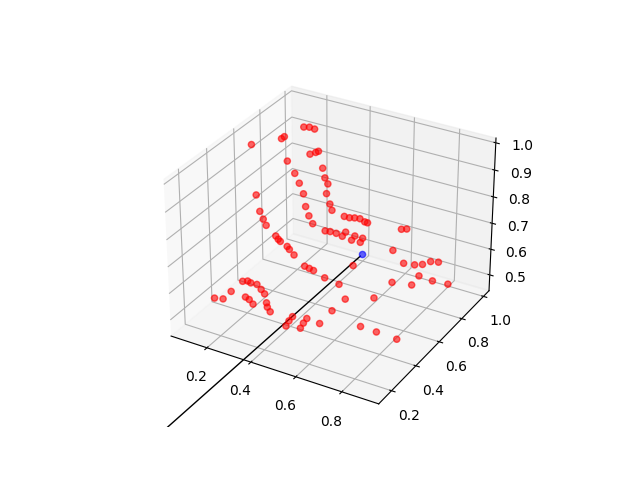

In [72]:
%matplotlib widget
from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(points[:-1,0], points[:-1,1], points[:-1,2],marker='o', s=20, c="red", alpha=0.6)
ax.scatter3D(points[-1,0], points[-1,1], points[-1,2],marker='o', s=20, c="blue", alpha=0.6)
ax.arrow3D(head[0],head[1],head[2],xyz[0],xyz[1],xyz[2],mutation_scale=20,arrowstyle="-|>",)